### Use SHAP to examine how parameters influence prediction

In [1]:
import tensorflow as tf
import keras
import shap
import numpy as np
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import pyplot as plt
import os

if "notebooks" in os.getcwd():
    os.chdir("..")

shap.initjs()

### Load model

In [2]:
# Load the model
# Keras needs to know about the custom metric for classification models
# def pct_positive_cases(y_true, y_pred):
#     return tf.math.reduce_mean(y_true)

model = keras.saving.load_model(
    "data_working/models/preisler_regr_noyear.keras", 
)

In [3]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ fire (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ near (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latitude            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ longitude           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prcp1 (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prcp2 (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prcp3 (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prcp4 (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rhost (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ winter_tmin         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 10)        │          0 │ fire[0][0],       │
│ (Concatenate)       │                   │            │ near[0][0],       │
│                     │                   │            │ latitude[0][0],   │
│                     │                   │            │ longitude[0][0],  │
│                     │                   │            │ prcp1[0][0],      │
│                     │                   │            │ prcp2[0][0],      │
│                     │                   │            │ prcp3[0][0],      │
│                     │                   │            │ prcp4[0][0],      │
│                     │                   │            │ rhost[0][0],      │
│                     │                   │            │ winter_tmin[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 10)        │         40 │ concatenate_1[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │      1,408 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 16)        │      2,064 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 8)         │        136 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pct_mortality       │ (None, 1)         │          9 │ dense_5[0][0]     │
│ (Dense)             │                   │            │                 

 Total params: 10,933 (42.71 KB)

 Trainable params: 3,637 (14.21 KB)

 Non-trainable params: 20 (80.00 B)

 Optimizer params: 7,276 (28.43 KB)

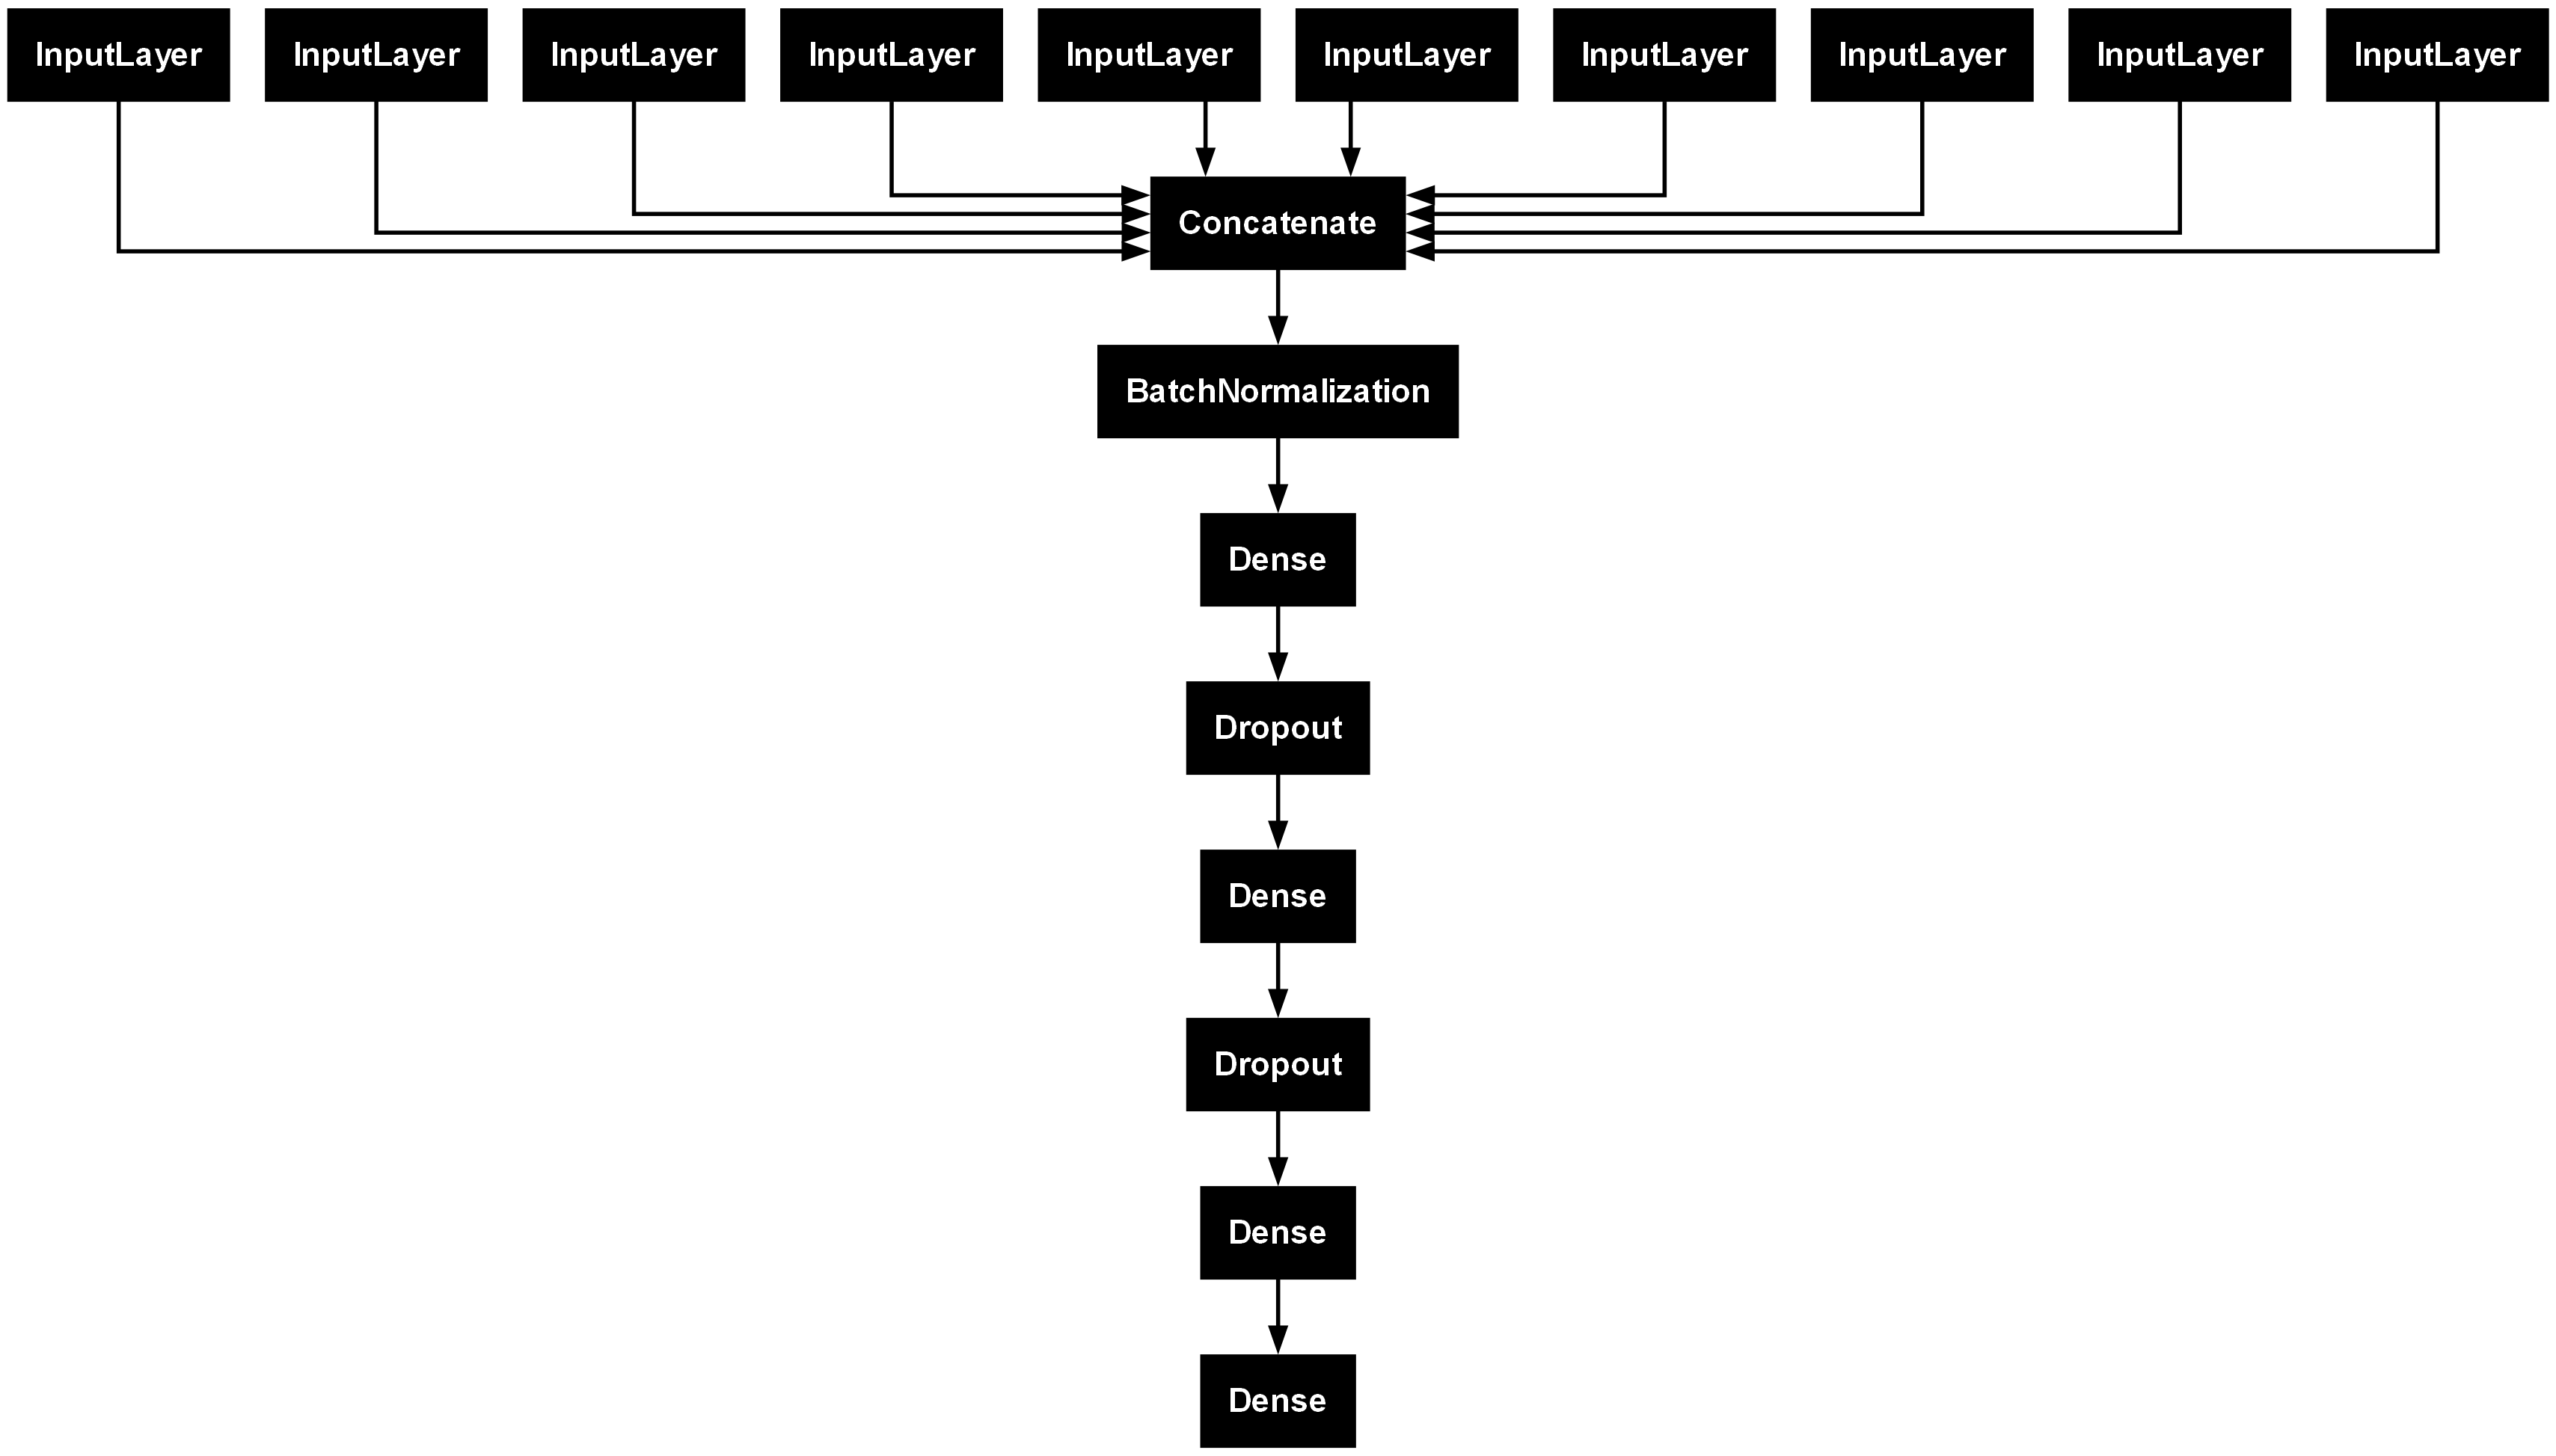

In [4]:
keras.utils.plot_model(model)

### Load background data

In [5]:
from google.cloud.storage import Client

client = Client(project="forest-lst")
bucket = "preisler_tfdata"

records = [
    "/".join(["gs://{}".format(bucket), f.name])
    for f in client.list_blobs(bucket, prefix="preisler-rectangular")
    if f.name.endswith("csv") and "v2" not in f.name
]

ds = pd.concat((pd.read_csv(f).drop(["system:index", ".geo"], axis=1) for f in records), ignore_index=True)
bg = ds.sample(n=1000)

In [6]:
bg.head()

,fire,latitude,longitude,near,pct_mortality,prcp1,prcp2,prcp3,prcp4,rhost,winter_tmin,year
63166,0.00000,33.979130,-116.727088,0.0044,0.0000,733.415072,198.876374,294.460171,72.745474,0.114984,-6.340392,2006
120503,0.00000,37.278518,-119.242371,0.0420,0.0000,705.670560,634.459360,1673.432930,1677.046614,0.973674,-14.985329,2009
37755,0.00000,34.276575,-116.798953,0.0000,0.0160,563.475189,108.758182,302.625277,311.515192,0.957660,-11.896755,2004
43004,0.00000,39.225332,-120.176619,0.0068,0.8864,1043.946419,954.023520,578.771412,988.020250,0.113600,-17.224693,2004
341772,0.07125,40.712313,-122.476306,0.1708,0.0540,675.259540,952.995159,2007.457856,961.231450,0.570244,-3.631123,2022


In [7]:
# Verify that the predictions are possible and reasonable
target = "pct_mortality"
bands  = ["fire", "near", "latitude", "longitude", "prcp1", "prcp2", "prcp3", "prcp4", "rhost", "winter_tmin"]

def convert_to_tf_input(df):
    return [
        df[b].to_numpy() for b in bands
    ]

y = bg[target].to_numpy()
X = convert_to_tf_input(bg[bands])

In [8]:
X[0].shape

(1000,)

In [9]:
y_hat = model.predict(X).squeeze()

 1/32 ━━━━━━━━━━━━━━━━━━━━ 7s 251ms/step

c:\Users\rsgal\miniforge3\envs\forest_mort\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['fire', 'near', 'latitude', 'longitude', 'prcp1', 'prcp2', 'prcp3', 'prcp4', 'rhost', 'winter_tmin']. Received: the structure of inputs=('*', '*', '*', '*', '*', '*', '*', '*', '*', '*')
  warnings.warn(


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


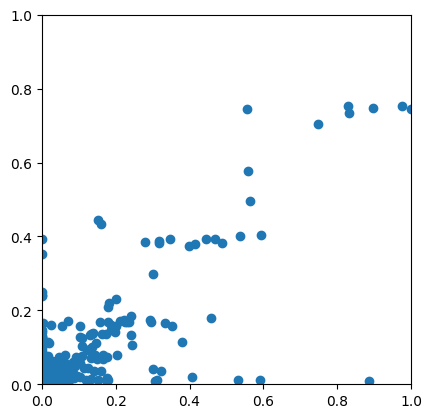

In [10]:
plt.scatter(y, y_hat)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect("equal")
plt.show()

Looks good!

### Run an explainer

For whatever reason, SHAP doesn't like to work with models that have multiple inputs (see github issue [here](https://github.com/shap/shap/issues/1945)). However, SHAP works fine when we use a model that takes a 2D array as input. Since our first model step is to concatenate all the features together, we can build a submodel whose input is the concatenated layer and move on as normal.

In [11]:
model.layers

[<InputLayer name=fire, built=True>,
 <InputLayer name=near, built=True>,
 <InputLayer name=latitude, built=True>,
 <InputLayer name=longitude, built=True>,
 <InputLayer name=prcp1, built=True>,
 <InputLayer name=prcp2, built=True>,
 <InputLayer name=prcp3, built=True>,
 <InputLayer name=prcp4, built=True>,
 <InputLayer name=rhost, built=True>,
 <InputLayer name=winter_tmin, built=True>,
 <Concatenate name=concatenate_1, built=True>,
 <BatchNormalization name=batch_normalization_1, built=True>,
 <Dense name=dense_3, built=True>,
 <Dropout name=dropout_2, built=True>,
 <Dense name=dense_4, built=True>,
 <Dropout name=dropout_3, built=True>,
 <Dense name=dense_5, built=True>,
 <Dense name=pct_mortality, built=True>]

In [12]:
submodel = keras.models.Model(
    model.layers[10].output,
    model.layers[-1].output
)

bg_2d_array = bg[bands].to_numpy()

In [13]:
explainer = shap.DeepExplainer(submodel, bg_2d_array)
explanation = explainer(bg_2d_array)

c:\Users\rsgal\miniforge3\envs\forest_mort\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
c:\Users\rsgal\miniforge3\envs\forest_mort\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_10CLONE. Received: the structure of inputs=['*']
  warnings.warn(


In [14]:
explanation.values = explanation.values.squeeze()
explanation.feature_names = bands

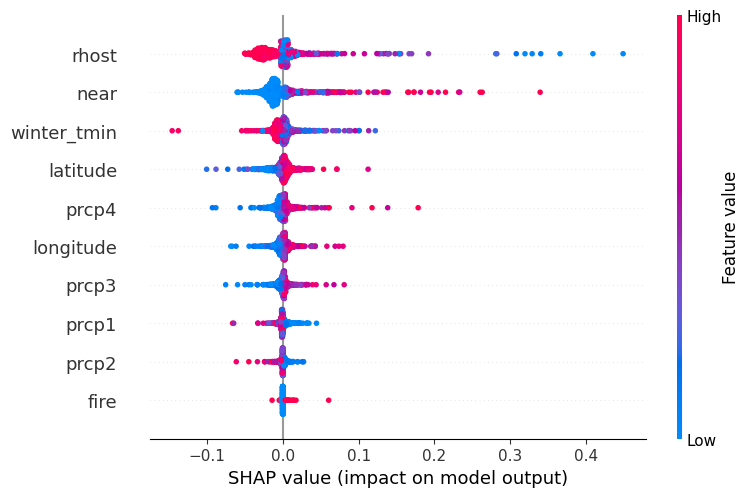

In [15]:
shap.plots.beeswarm(explanation)